In [1]:
import pyspark
from pyspark.sql.functions import *
import findspark

findspark.init()

In [46]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .config("spark.network.timeout", "36000s") \
    .master("local") \
    .appName("Music") \
    .getOrCreate()

In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark

In [5]:
bp_tracks = spark.read.format("csv").option("header", True).load("D:\\Big_data_minor\\bp_track.csv")
sp_tracks = spark.read.format("csv").option("header", True).load("D:\\Big_data_minor\\sp_track.csv")

In [6]:
SPBPjoined = sp_tracks.join(bp_tracks, sp_tracks.isrc == bp_tracks.isrc)

In [7]:
SPBPjoined.columns

['track_id',
 'track_title',
 'duration_ms',
 'isrc',
 'track_number',
 'release_id',
 'explicit',
 'disc_number',
 'preview_url',
 'updated_on',
 'track_id',
 'title',
 'mix',
 'is_remixed',
 'release_date',
 'genre_id',
 'subgenre_id',
 'track_url',
 'bpm',
 'duration',
 'duration_ms',
 'isrc',
 'key_id',
 'label_id',
 'release_id',
 'updated_on',
 'is_matched_spot']

# Dropping duplicated columns in the dataset

In [8]:
# dropping duplicate and useless columns.
# SPBPjoined = SPBPjoined.drop(sp_tracks.track_title)
SPBPjoined = SPBPjoined.drop(sp_tracks.isrc) 
SPBPjoined = SPBPjoined.drop(sp_tracks.preview_url)
# SPBPjoined = SPBPjoined.drop(bp_tracks.preview_url)
SPBPjoined = SPBPjoined.drop(sp_tracks.track_number) 
# SPBPjoined = SPBPjoined.drop(bp_tracks.track_number) 
SPBPjoined = SPBPjoined.drop(sp_tracks.release_id)
SPBPjoined = SPBPjoined.drop(bp_tracks.release_id)
SPBPjoined = SPBPjoined.drop(sp_tracks.updated_on) 
SPBPjoined = SPBPjoined.drop(bp_tracks.updated_on) 
SPBPjoined = SPBPjoined.drop(bp_tracks.track_id) 
SPBPjoined = SPBPjoined.drop(sp_tracks.track_id)
# SPBPjoined = SPBPjoined.drop(sp_tracks.mix) 
SPBPjoined = SPBPjoined.drop(bp_tracks.mix)
SPBPjoined = SPBPjoined.drop(bp_tracks.track_url)
# SPBPjoined = SPBPjoined.drop(sp_tracks.track_url)
# SPBPjoined = SPBPjoined.drop(sp_tracks.duration)
SPBPjoined = SPBPjoined.drop(bp_tracks.duration)
# SPBPjoined = SPBPjoined.drop(sp_tracks.key_id)
SPBPjoined = SPBPjoined.drop(bp_tracks.key_id)
# SPBPjoined = SPBPjoined.drop(sp_tracks.label_id) 
SPBPjoined = SPBPjoined.drop(bp_tracks.label_id)
SPBPjoined = SPBPjoined.drop(sp_tracks.release_id)
SPBPjoined = SPBPjoined.drop(bp_tracks.release_id)
SPBPjoined = SPBPjoined.drop(sp_tracks.updated_on) 
SPBPjoined = SPBPjoined.drop(bp_tracks.updated_on) 

In [9]:
# Drop duplicate rows based on the 'isrc' column
SPBPjoined = SPBPjoined.dropDuplicates(['isrc'])

## JOINING AUDIO FEAUTURES

In [10]:
aud_feat = spark.read.format("csv").option("header", True).load("D:\\Big_data_minor\\audio_features.csv")

In [11]:
SPBPjoined=SPBPjoined.drop("duration_ms")

In [12]:
SPBPjoined.columns

['track_title',
 'explicit',
 'disc_number',
 'title',
 'is_remixed',
 'release_date',
 'genre_id',
 'subgenre_id',
 'bpm',
 'isrc',
 'is_matched_spot']

In [13]:
joined_df = SPBPjoined.join(aud_feat, SPBPjoined.isrc == aud_feat.isrc)
joined_df.columns

['track_title',
 'explicit',
 'disc_number',
 'title',
 'is_remixed',
 'release_date',
 'genre_id',
 'subgenre_id',
 'bpm',
 'isrc',
 'is_matched_spot',
 'isrc',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'time_signature',
 'valence',
 'updated_on']

In [14]:
joined_df= joined_df.drop("release_date","updated_on", "key","subgenre_id")


   - get genre name
   - remove genre id,and remaining genre id file
   - is_matched_spot
   - remove disc number
   - remove mode
   - remove time signature



In [15]:
joined_df= joined_df.drop("is_matched_spot","disc_number", " mode","time_signature") 
joined_df.columns

['track_title',
 'explicit',
 'title',
 'is_remixed',
 'genre_id',
 'bpm',
 'isrc',
 'isrc',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'valence']

### Current Objectives
- join artist with data to validate data (FOR THE LOVE OF GOD)
- check for nulls and incompelete data
- RUN MODEL PLEASE

In [16]:
#read artist and artist_track tables
sp_artist = spark.read.format("csv").option("header", True).load("D:\\Big_data_minor\\sp_artist.csv")
sp_artist_track = spark.read.format("csv").option("header", True).load("D:\\Big_data_minor\\sp_artist_track.csv")

In [17]:
artists = sp_artist.select("artist_id", "artist_name")
artist_track = sp_artist_track.select("track_id", "artist_id")
artists.columns, artist_track.columns

(['artist_id', 'artist_name'], ['track_id', 'artist_id'])

In [18]:
artist_track = artist_track.join(artists, artists.artist_id == artist_track.artist_id).select("artist_name", "track_id")
artist_track.columns

['artist_name', 'track_id']

In [19]:
artistTracks = artist_track.join(sp_tracks, artist_track.track_id == sp_tracks.track_id).select("artist_name", "track_title", "isrc")
artistTracks.columns

['artist_name', 'track_title', 'isrc']

In [20]:
artistTracks.select("track_title", "artist_name").filter(artistTracks.track_title == "I'm Still Standing")

+------------------+-------------------+
|       track_title|        artist_name|
+------------------+-------------------+
|I'm Still Standing|           Enawadan|
|I'm Still Standing|              Nayer|
|I'm Still Standing|             Pashaa|
|I'm Still Standing|Anything But Monday|
|I'm Still Standing|           Enawadan|
|I'm Still Standing|     Ryunosuke Kudo|
|I'm Still Standing|        Stee Downes|
|I'm Still Standing|      Thomaz Krauze|
|I'm Still Standing|      The Moleskins|
+------------------+-------------------+

In [21]:
#read artist and artist_track tables
bp_artist = spark.read.format("csv").option("header", True).load("D:\\Big_data_minor\\bp_artist.csv")
bp_artist_track = spark.read.format("csv").option("header", True).load("D:\\Big_data_minor\\bp_artist_track.csv")

In [22]:
bpartists = bp_artist.select("artist_id", "artist_name")
bpartist_track = bp_artist_track.select("track_id", "artist_id")
bpartists.columns, bpartist_track.columns

(['artist_id', 'artist_name'], ['track_id', 'artist_id'])

In [23]:
bpartist_track = bpartist_track.join(bpartists, bpartists.artist_id == bpartist_track.artist_id).select("artist_name", "track_id")
bp_tracks.columns

['track_id',
 'title',
 'mix',
 'is_remixed',
 'release_date',
 'genre_id',
 'subgenre_id',
 'track_url',
 'bpm',
 'duration',
 'duration_ms',
 'isrc',
 'key_id',
 'label_id',
 'release_id',
 'updated_on',
 'is_matched_spot']

In [24]:
bpartistTracks = bpartist_track.join(bp_tracks, bpartist_track.track_id == bp_tracks.track_id).select("artist_name", "title", "isrc")
bpartistTracks.columns

['artist_name', 'title', 'isrc']

In [25]:
joined_df.columns

['track_title',
 'explicit',
 'title',
 'is_remixed',
 'genre_id',
 'bpm',
 'isrc',
 'isrc',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'valence']

In [26]:
sp_tracks.drop_duplicates().count()

5777707

In [27]:
joined_df.printSchema()

root
 |-- track_title: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- title: string (nullable = true)
 |-- is_remixed: string (nullable = true)
 |-- genre_id: string (nullable = true)
 |-- bpm: string (nullable = true)
 |-- isrc: string (nullable = true)
 |-- isrc: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- valence: string (nullable = true)



In [28]:
joined_df = joined_df.drop("genre_id", "mode")

In [29]:
numerical_cols = ["bpm", "acousticness", "danceability",
                  "energy", "instrumentalness",
                  "liveness", "loudness", "speechiness", "tempo",
                  "valence"]

In [30]:
from pyspark.sql.types import *

In [31]:
for column in numerical_cols:
    joined_df = joined_df.withColumn(column, col(column).cast(FloatType()))
joined_df.printSchema()

root
 |-- track_title: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- title: string (nullable = true)
 |-- is_remixed: string (nullable = true)
 |-- bpm: float (nullable = true)
 |-- isrc: string (nullable = true)
 |-- isrc: string (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- danceability: float (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- energy: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- valence: float (nullable = true)



In [32]:
from sklearn import preprocessing

categorical_columns = ['explicit', 'is_remixed']
for column in categorical_columns:
    joined_df = joined_df.withColumn(column, when(col(column) == 't', 1).otherwise(0).cast("int"))

joined_df.printSchema()

root
 |-- track_title: string (nullable = true)
 |-- explicit: integer (nullable = false)
 |-- title: string (nullable = true)
 |-- is_remixed: integer (nullable = false)
 |-- bpm: float (nullable = true)
 |-- isrc: string (nullable = true)
 |-- isrc: string (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- danceability: float (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- energy: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- valence: float (nullable = true)



In [33]:
numerical_cols = numerical_cols + categorical_columns
numerical_cols

['bpm',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence',
 'explicit',
 'is_remixed']

In [34]:
final_df = joined_df
final_df = final_df.drop("isrc")
final_df.printSchema()

root
 |-- track_title: string (nullable = true)
 |-- explicit: integer (nullable = false)
 |-- title: string (nullable = true)
 |-- is_remixed: integer (nullable = false)
 |-- bpm: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- danceability: float (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- energy: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- valence: float (nullable = true)



In [35]:
row_count = final_df.count()
print(f"Total number of rows: {row_count}")

Total number of rows: 4666818


In [36]:
final_df = final_df.limit(10000)

columns_to_check = ['bpm', 'danceability', 'energy', 'acousticness', 
                    'instrumentalness', 'liveness', 'loudness', 
                    'speechiness', 'tempo', 'valence']
final_df_cleaned = final_df.dropna(subset=columns_to_check)

In [37]:
from pyspark.sql import functions as F

# Define numerical columns for normalization
numerical_columns = ["bpm", "acousticness", "danceability", "energy", 
                     "instrumentalness", "liveness", "loudness", 
                     "speechiness", "tempo", "valence"]

# Define the min and max values for each column
min_max_values = {
    "bpm": (0, 250),
    "acousticness": (0, 1),
    "danceability": (0, 1),
    "energy": (0, 1),
    "instrumentalness": (0, 1),
    "liveness": (0, 1),
    "loudness": (-60, 0),
    "speechiness": (0, 1),
    "tempo": (0, 250),
    "valence": (0, 1),
}

# Initialize the DataFrame to hold the normalized values
normalized_df = final_df_cleaned

# Normalize each column using the predefined min and max values
for column in numerical_columns:
    min_val, max_val = min_max_values[column]
    
    # Normalize the current column and add it to the DataFrame
    normalized_col = ((F.col(column) - F.lit(min_val)) /
                      (F.lit(max_val) - F.lit(min_val))).alias(f"{column}_normalized")
    
    normalized_df = normalized_df.withColumn(f"{column}_normalized", normalized_col)

# Verify the schema and display the first few rows      
normalized_df.printSchema()



root
 |-- track_title: string (nullable = true)
 |-- explicit: integer (nullable = false)
 |-- title: string (nullable = true)
 |-- is_remixed: integer (nullable = false)
 |-- bpm: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- danceability: float (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- energy: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- bpm_normalized: double (nullable = true)
 |-- acousticness_normalized: double (nullable = true)
 |-- danceability_normalized: double (nullable = true)
 |-- energy_normalized: double (nullable = true)
 |-- instrumentalness_normalized: double (nullable = true)
 |-- liveness_normalized: double (nullable = true)
 |-- loudness_normalized: double (nullable = true)
 |-- speechiness_norma

In [38]:
normalized_df.show(5)

+------------+--------+--------------------+----------+-----+------------+------------+-----------+------+----------------+--------+--------+-----------+-----+-------+--------------+-----------------------+-----------------------+-------------------+---------------------------+-------------------+-------------------+----------------------+----------------+-------------------+
| track_title|explicit|               title|is_remixed|  bpm|acousticness|danceability|duration_ms|energy|instrumentalness|liveness|loudness|speechiness|tempo|valence|bpm_normalized|acousticness_normalized|danceability_normalized|  energy_normalized|instrumentalness_normalized|liveness_normalized|loudness_normalized|speechiness_normalized|tempo_normalized| valence_normalized|
+------------+--------+--------------------+----------+-----+------------+------------+-----------+------+----------------+--------+--------+-----------+-----+-------+--------------+-----------------------+-----------------------+------------

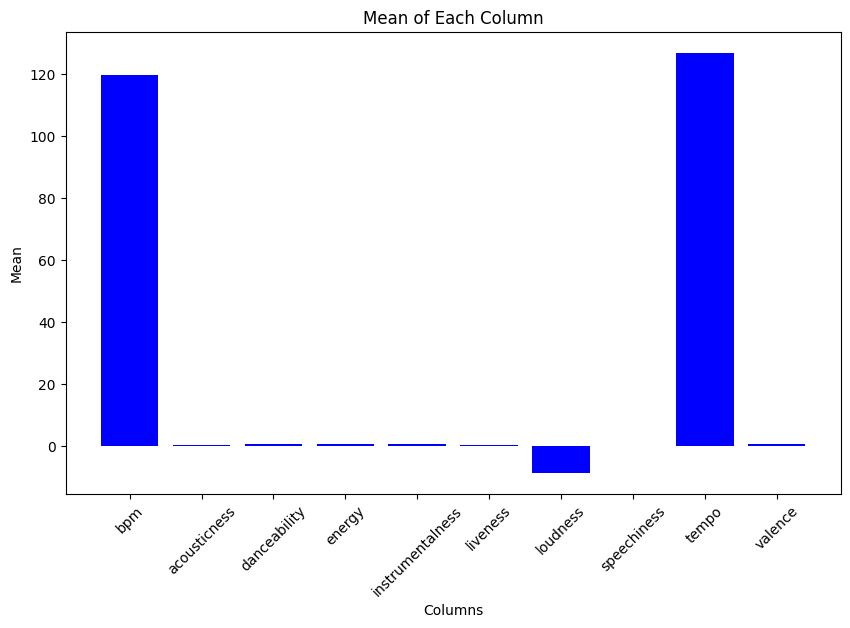

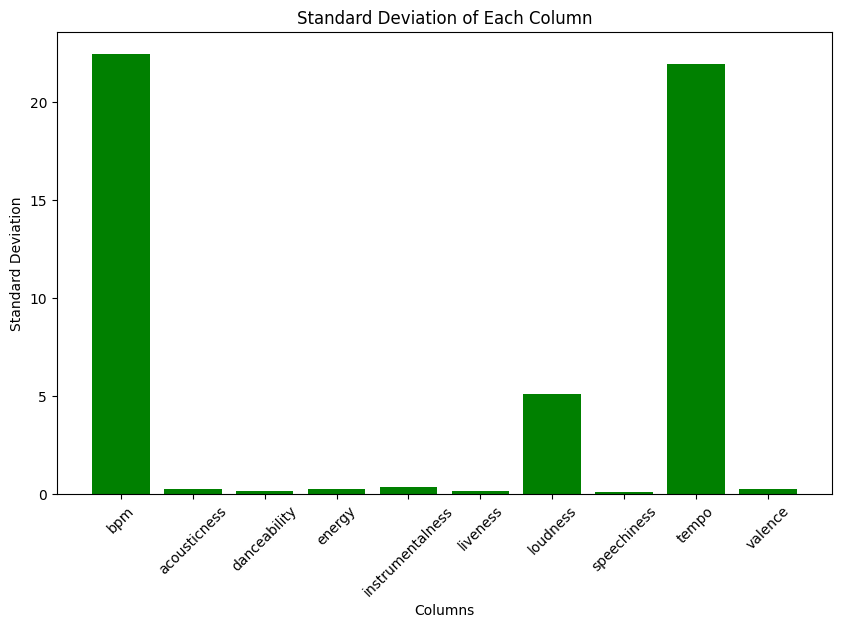

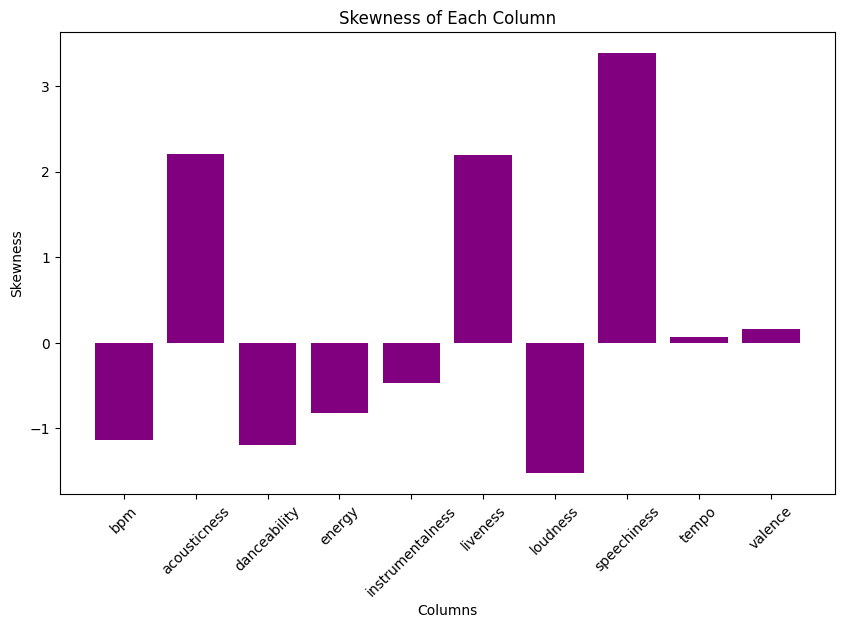

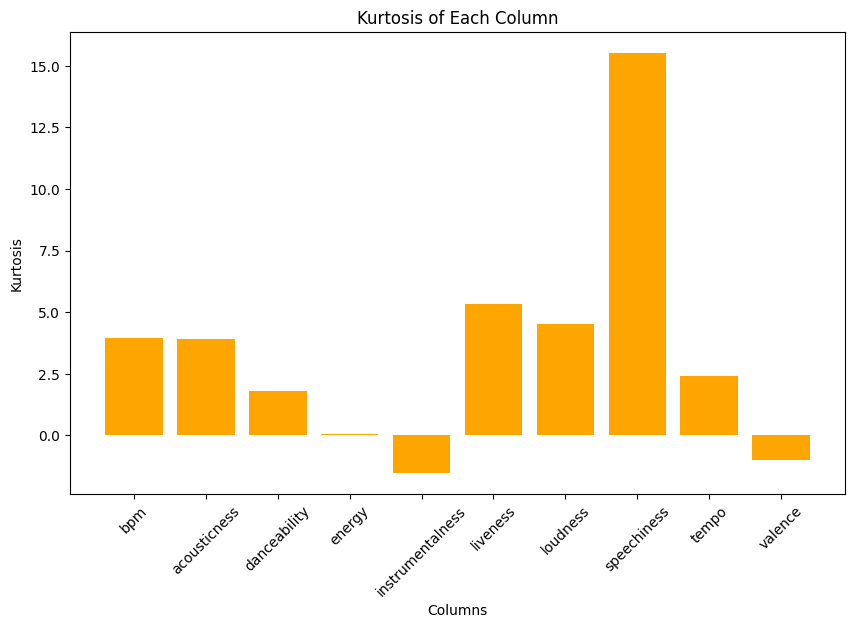

In [43]:
from pyspark.sql.functions import mean, stddev, skewness, kurtosis
import matplotlib.pyplot as plt

# Numerical columns
numerical_columns = ["bpm", "acousticness", "danceability", "energy", 
                     "instrumentalness", "liveness", "loudness", "speechiness", 
                     "tempo", "valence"]

# Compute statistics for each column
stats = normalized_df.select(
    *[mean(c).alias(f'mean_{c}') for c in numerical_columns],
    *[stddev(c).alias(f'stddev_{c}') for c in numerical_columns],
    *[skewness(c).alias(f'skewness_{c}') for c in numerical_columns],
    *[kurtosis(c).alias(f'kurtosis_{c}') for c in numerical_columns]
).collect()[0]

# Extracting stats
means = [stats[f'mean_{c}'] for c in numerical_columns]
stddevs = [stats[f'stddev_{c}'] for c in numerical_columns]
skewnesses = [stats[f'skewness_{c}'] for c in numerical_columns]
kurtoses = [stats[f'kurtosis_{c}'] for c in numerical_columns]

# Plotting each of the statistics

# 1. Mean Plot
plt.figure(figsize=(10, 6))
plt.bar(numerical_columns, means, color='blue')
plt.title('Mean of Each Column')
plt.xlabel('Columns')
plt.ylabel('Mean')
plt.xticks(rotation=45)
plt.show()

# 2. Standard Deviation Plot
plt.figure(figsize=(10, 6))
plt.bar(numerical_columns, stddevs, color='green')
plt.title('Standard Deviation of Each Column')
plt.xlabel('Columns')
plt.ylabel('Standard Deviation')
plt.xticks(rotation=45)
plt.show()

# 3. Skewness Plot
plt.figure(figsize=(10, 6))
plt.bar(numerical_columns, skewnesses, color='purple')
plt.title('Skewness of Each Column')
plt.xlabel('Columns')
plt.ylabel('Skewness')
plt.xticks(rotation=45)
plt.show()

# 4. Kurtosis Plot
plt.figure(figsize=(10, 6))
plt.bar(numerical_columns, kurtoses, color='orange')
plt.title('Kurtosis of Each Column')
plt.xlabel('Columns')
plt.ylabel('Kurtosis')
plt.xticks(rotation=45)
plt.show()



In [35]:
from pyspark.sql.functions import col, isnan, when, count

final_df.select([count(when(col(c).isNull(), c)).alias(c) for c in final_df.columns]).show()

+-----------+--------+-----+----------+---+------------+------------+-----------+------+----------------+--------+--------+-----------+-----+-------+
|track_title|explicit|title|is_remixed|bpm|acousticness|danceability|duration_ms|energy|instrumentalness|liveness|loudness|speechiness|tempo|valence|
+-----------+--------+-----+----------+---+------------+------------+-----------+------+----------------+--------+--------+-----------+-----+-------+
|          0|       0|    0|         0|  0|           0|           0|          0|     0|               0|       0|       0|          0|    0|      0|
+-----------+--------+-----+----------+---+------------+------------+-----------+------+----------------+--------+--------+-----------+-----+-------+



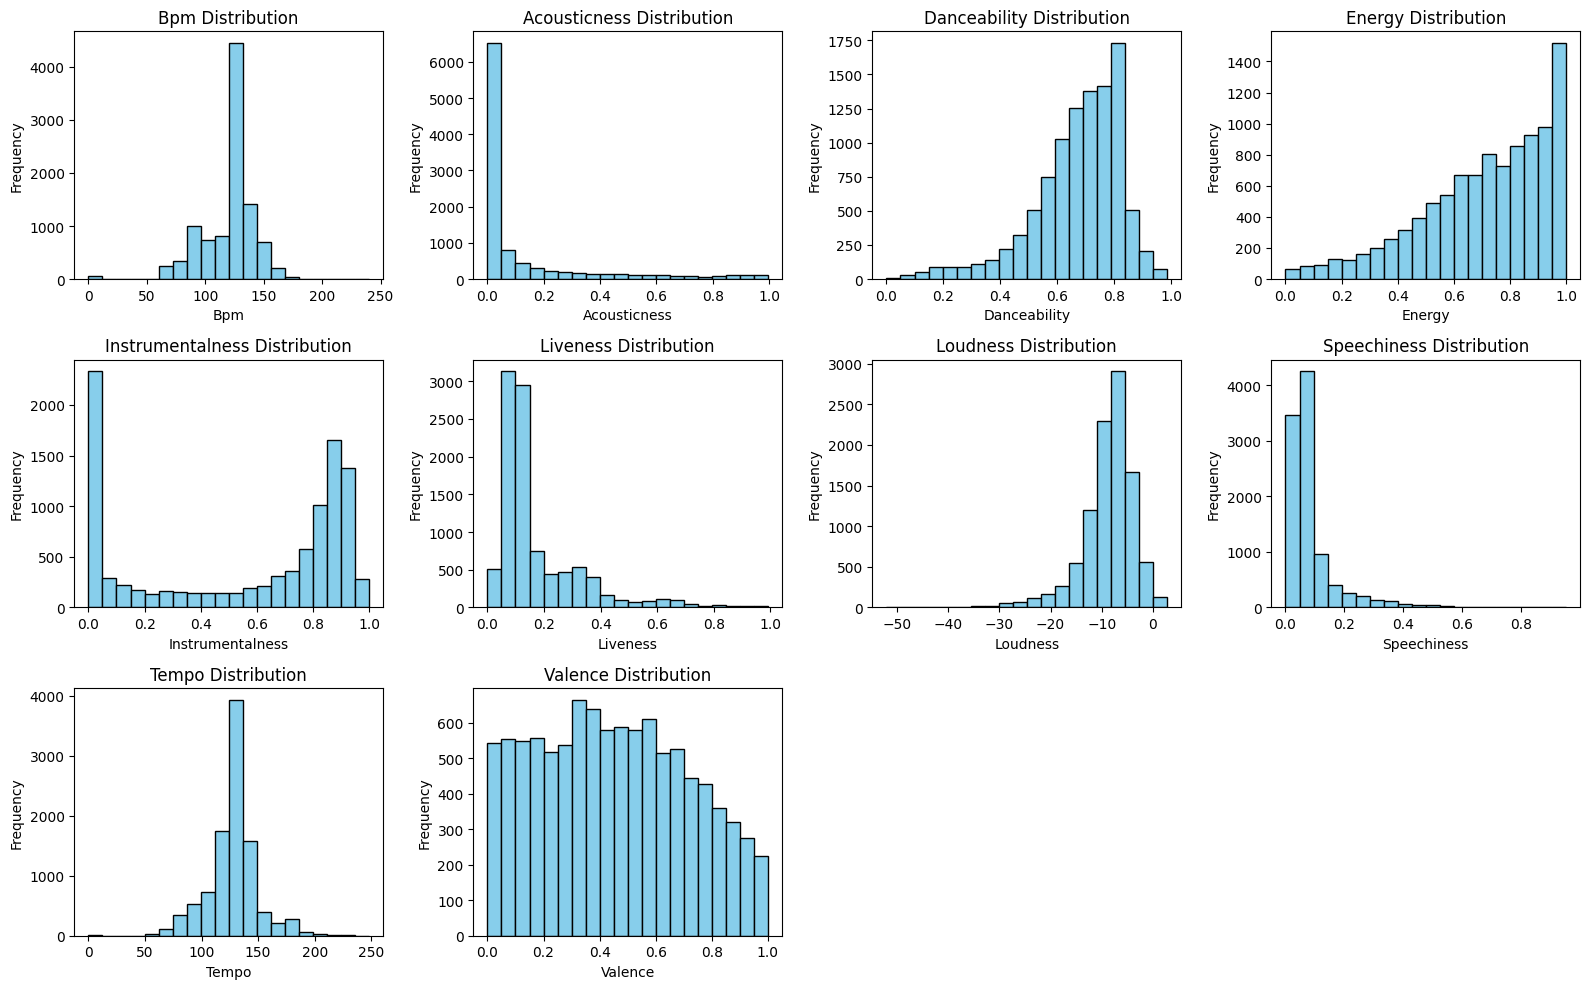

In [72]:
import matplotlib.pyplot as plt

numerical_columns = ["bpm", "acousticness", "danceability", "energy", 
                     "instrumentalness", "liveness", "loudness", "speechiness", 
                     "tempo", "valence"]
 
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    data = final_df_cleaned.select(column).rdd.flatMap(lambda x: x).collect()
    axes[i].hist(data, bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'{column.capitalize()} Distribution')
    axes[i].set_xlabel(column.capitalize())
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

numerical_columns = ["bpm", "acousticness", "danceability", "energy", 
                     "instrumentalness", "liveness", "loudness", 
                     "speechiness", "tempo", "valence"]


In [44]:
# Initialize an empty matrix for the heatmap
corr_matrix = np.zeros((len(numerical_columns), len(numerical_columns)))

# Calculate correlation values for the filtered DataFrame
for i, col1 in enumerate(numerical_columns):
    for j, col2 in enumerate(numerical_columns):
        corr_value = normalized_df.stat.corr(col1, col2)
        corr_matrix[i][j] = corr_value
        # Print correlation values
        print(f"Correlation between {col1} and {col2}: {corr_value}")


Correlation between bpm and bpm: 1.0


Correlation between bpm and acousticness: -0.1936197311985891


Correlation between bpm and danceability: 0.13671351168781076


Correlation between bpm and energy: 0.2493022520056432


Correlation between bpm and instrumentalness: 0.00381570220691186


Correlation between bpm and liveness: -0.004036304729542746


Correlation between bpm and loudness: 0.19027457508155696


Correlation between bpm and speechiness: -0.10908969108084005


Correlation between bpm and tempo: 0.18387673590082523


Correlation between bpm and valence: 0.12061076494870131


Correlation between acousticness and bpm: -0.1936197311985892


Correlation between acousticness and acousticness: 1.0


Correlation between acousticness and danceability: -0.3427819357296136


Correlation between acousticness and energy: -0.5152521632099709


Correlation between acousticness and instrumentalness: 0.07131299103391094


Correlation between acousticness and liveness: -0.049939965144904314


Correlation between acousticness and loudness: -0.46529085591260844


Correlation between acousticness and speechiness: 0.021036835111788353


Correlation between acousticness and tempo: -0.21582144424729602


Correlation between acousticness and valence: -0.16986555298256023


Correlation between danceability and bpm: 0.1367135116878108


Correlation between danceability and acousticness: -0.3427819357296136


Correlation between danceability and danceability: 1.0


Correlation between danceability and energy: 0.17198382230971407


Correlation between danceability and instrumentalness: 0.004355944545368403


Correlation between danceability and liveness: -0.13207583835680786


Correlation between danceability and loudness: 0.23767258822507753


Correlation between danceability and speechiness: 0.06683938441714016


Correlation between danceability and tempo: 0.0280678074529603


Correlation between danceability and valence: 0.36069424641094233


Correlation between energy and bpm: 0.24930225200564335


Correlation between energy and acousticness: -0.5152521632099709


Correlation between energy and danceability: 0.1719838223097142


Correlation between energy and energy: 1.0


Correlation between energy and instrumentalness: -0.15656767824854614


Correlation between energy and liveness: 0.16227916184906052


Correlation between energy and loudness: 0.7553214270845753


Correlation between energy and speechiness: 0.004558308045955183


Correlation between energy and tempo: 0.27482380072598506


Correlation between energy and valence: 0.2766040437690104


Correlation between instrumentalness and bpm: 0.0038157022069118716


Correlation between instrumentalness and acousticness: 0.07131299103391095


Correlation between instrumentalness and danceability: 0.0043559445453683985


Correlation between instrumentalness and energy: -0.15656767824854612


Correlation between instrumentalness and instrumentalness: 1.0


Correlation between instrumentalness and liveness: -0.14228343118547726


Correlation between instrumentalness and loudness: -0.33015026140865106


Correlation between instrumentalness and speechiness: -0.2264210191996109


Correlation between instrumentalness and tempo: 0.011670570944923997


Correlation between instrumentalness and valence: -0.16593122558706438


Correlation between liveness and bpm: -0.0040363047295427406


Correlation between liveness and acousticness: -0.04993996514490434


Correlation between liveness and danceability: -0.13207583835680786


Correlation between liveness and energy: 0.1622791618490606


Correlation between liveness and instrumentalness: -0.1422834311854773


Correlation between liveness and liveness: 1.0


Correlation between liveness and loudness: 0.12446038417564828


Correlation between liveness and speechiness: 0.09966456579352223


Correlation between liveness and tempo: 0.033249762684314864


Correlation between liveness and valence: -0.00867072639514044


Correlation between loudness and bpm: 0.1902745750815569


Correlation between loudness and acousticness: -0.46529085591260844


Correlation between loudness and danceability: 0.23767258822507756


Correlation between loudness and energy: 0.7553214270845753


Correlation between loudness and instrumentalness: -0.3301502614086511


Correlation between loudness and liveness: 0.12446038417564831


Correlation between loudness and loudness: 1.0


Correlation between loudness and speechiness: 0.03840243739938588


Correlation between loudness and tempo: 0.20363776767021313


Correlation between loudness and valence: 0.29167778284717244


Correlation between speechiness and bpm: -0.10908969108084005


Correlation between speechiness and acousticness: 0.021036835111788357


Correlation between speechiness and danceability: 0.06683938441714013


Correlation between speechiness and energy: 0.004558308045955179


Correlation between speechiness and instrumentalness: -0.22642101919961105


Correlation between speechiness and liveness: 0.0996645657935222


Correlation between speechiness and loudness: 0.03840243739938588


Correlation between speechiness and speechiness: 1.0


Correlation between speechiness and tempo: 0.01927237838701025


Correlation between speechiness and valence: 0.037442749440745195


Correlation between tempo and bpm: 0.18387673590082523


Correlation between tempo and acousticness: -0.21582144424729605


Correlation between tempo and danceability: 0.028067807452960263


Correlation between tempo and energy: 0.27482380072598506


Correlation between tempo and instrumentalness: 0.011670570944924031


Correlation between tempo and liveness: 0.033249762684314864


Correlation between tempo and loudness: 0.2036377676702132


Correlation between tempo and speechiness: 0.0192723783870102


Correlation between tempo and tempo: 1.0


Correlation between tempo and valence: 0.07539094917351674


Correlation between valence and bpm: 0.12061076494870134


Correlation between valence and acousticness: -0.16986555298256026


Correlation between valence and danceability: 0.36069424641094233


Correlation between valence and energy: 0.2766040437690103


Correlation between valence and instrumentalness: -0.1659312255870644


Correlation between valence and liveness: -0.00867072639514044


Correlation between valence and loudness: 0.29167778284717244


Correlation between valence and speechiness: 0.03744274944074518


Correlation between valence and tempo: 0.07539094917351673


Correlation between valence and valence: 1.0


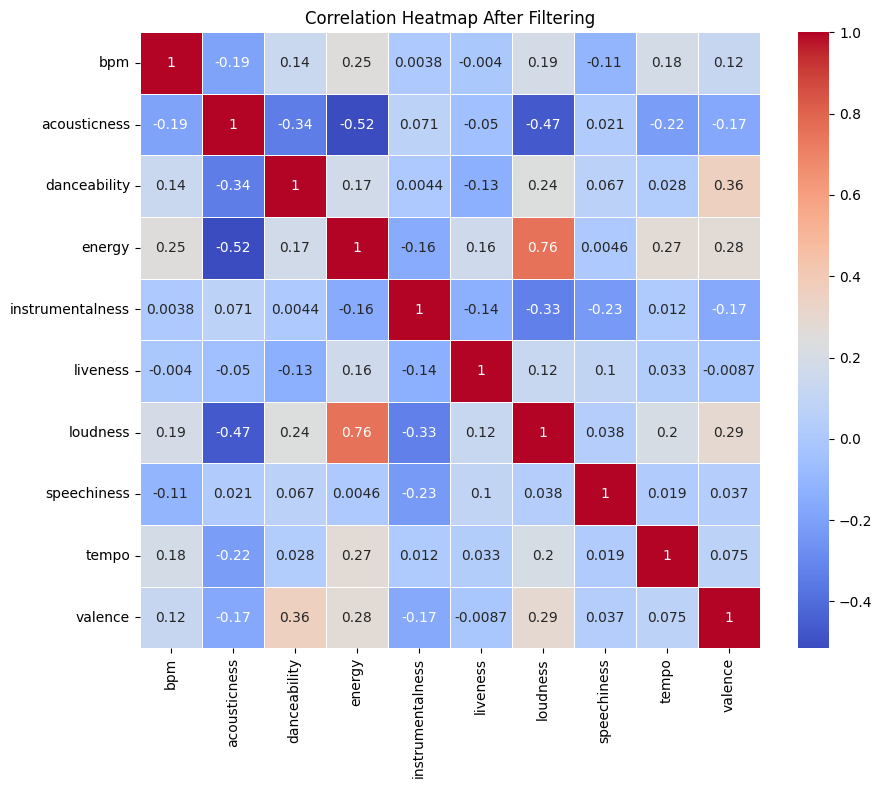

In [45]:
corr_df = pd.DataFrame(corr_matrix, index=numerical_columns, columns=numerical_columns)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm",      linewidths=0.5)
plt.title('Correlation Heatmap After Filtering')
plt.show()

# Comparative Analysis 

In [43]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

In [44]:
# Select numerical columns and convert them to FloatType
numerical_cols = ["bpm", "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence"]
for column in numerical_cols:
    normalized_df = normalized_df.withColumn(column, col(column).cast(FloatType()))
    

In [48]:
# Convert Spark DataFrame to Pandas DataFrame for easier manipulation in Scikit-learn
pandas_df = normalized_df.toPandas()

In [50]:
# Fill NaN values in only the numerical columns with their respective column means
numeric_cols = pandas_df.select_dtypes(include=['float64', 'int64']).columns
pandas_df[numeric_cols] = pandas_df[numeric_cols].fillna(pandas_df[numeric_cols].mean())


In [51]:
# Standardize numerical features
scaler = StandardScaler()
standardized_data = scaler.fit_transform(pandas_df[numerical_cols])

In [52]:
# K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(standardized_data)
pandas_df['KMeans_Cluster'] = kmeans_labels

In [53]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(standardized_data)
pandas_df['DBSCAN_Cluster'] = dbscan_labels

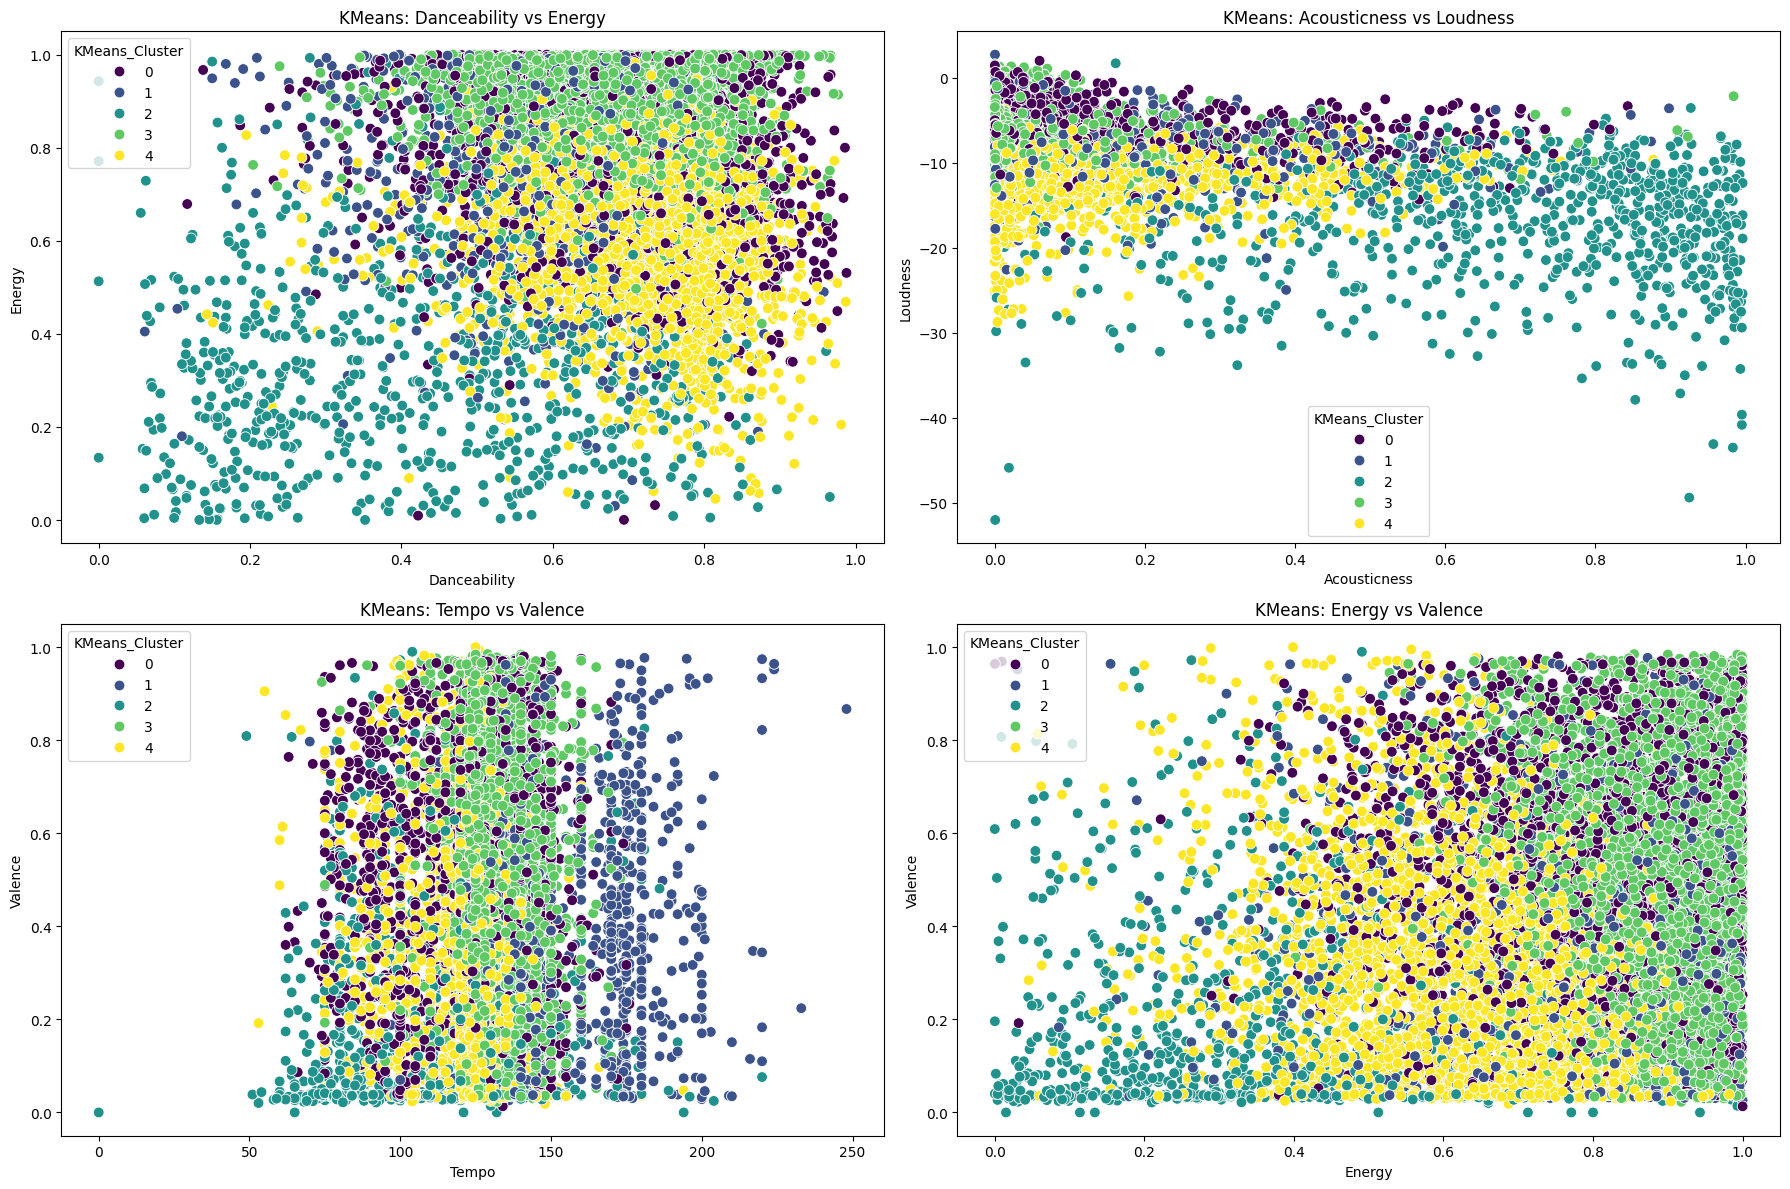

In [59]:
# Scatter plots for various feature combinations
plt.figure(figsize=(18, 12))

# Danceability vs. Energy
plt.subplot(2, 2, 1)
sns.scatterplot(data=pandas_df, x="danceability", y="energy", hue="KMeans_Cluster", palette="viridis", s=60)
plt.title("KMeans: Danceability vs Energy")
plt.xlabel("Danceability")
plt.ylabel("Energy")

# Acousticness vs. Loudness
plt.subplot(2, 2, 2)
sns.scatterplot(data=pandas_df, x="acousticness", y="loudness", hue="KMeans_Cluster", palette="viridis", s=60)
plt.title("KMeans: Acousticness vs Loudness")
plt.xlabel("Acousticness")
plt.ylabel("Loudness")

# Tempo vs. Valence
plt.subplot(2, 2, 3)
sns.scatterplot(data=pandas_df, x="tempo", y="valence", hue="KMeans_Cluster", palette="viridis", s=60)
plt.title("KMeans: Tempo vs Valence")
plt.xlabel("Tempo")
plt.ylabel("Valence")

# Energy vs. Valence
plt.subplot(2, 2, 4)
sns.scatterplot(data=pandas_df, x="energy", y="valence", hue="KMeans_Cluster", palette="viridis", s=60)
plt.title("KMeans: Energy vs Valence")
plt.xlabel("Energy")
plt.ylabel("Valence")

plt.tight_layout()
plt.show()

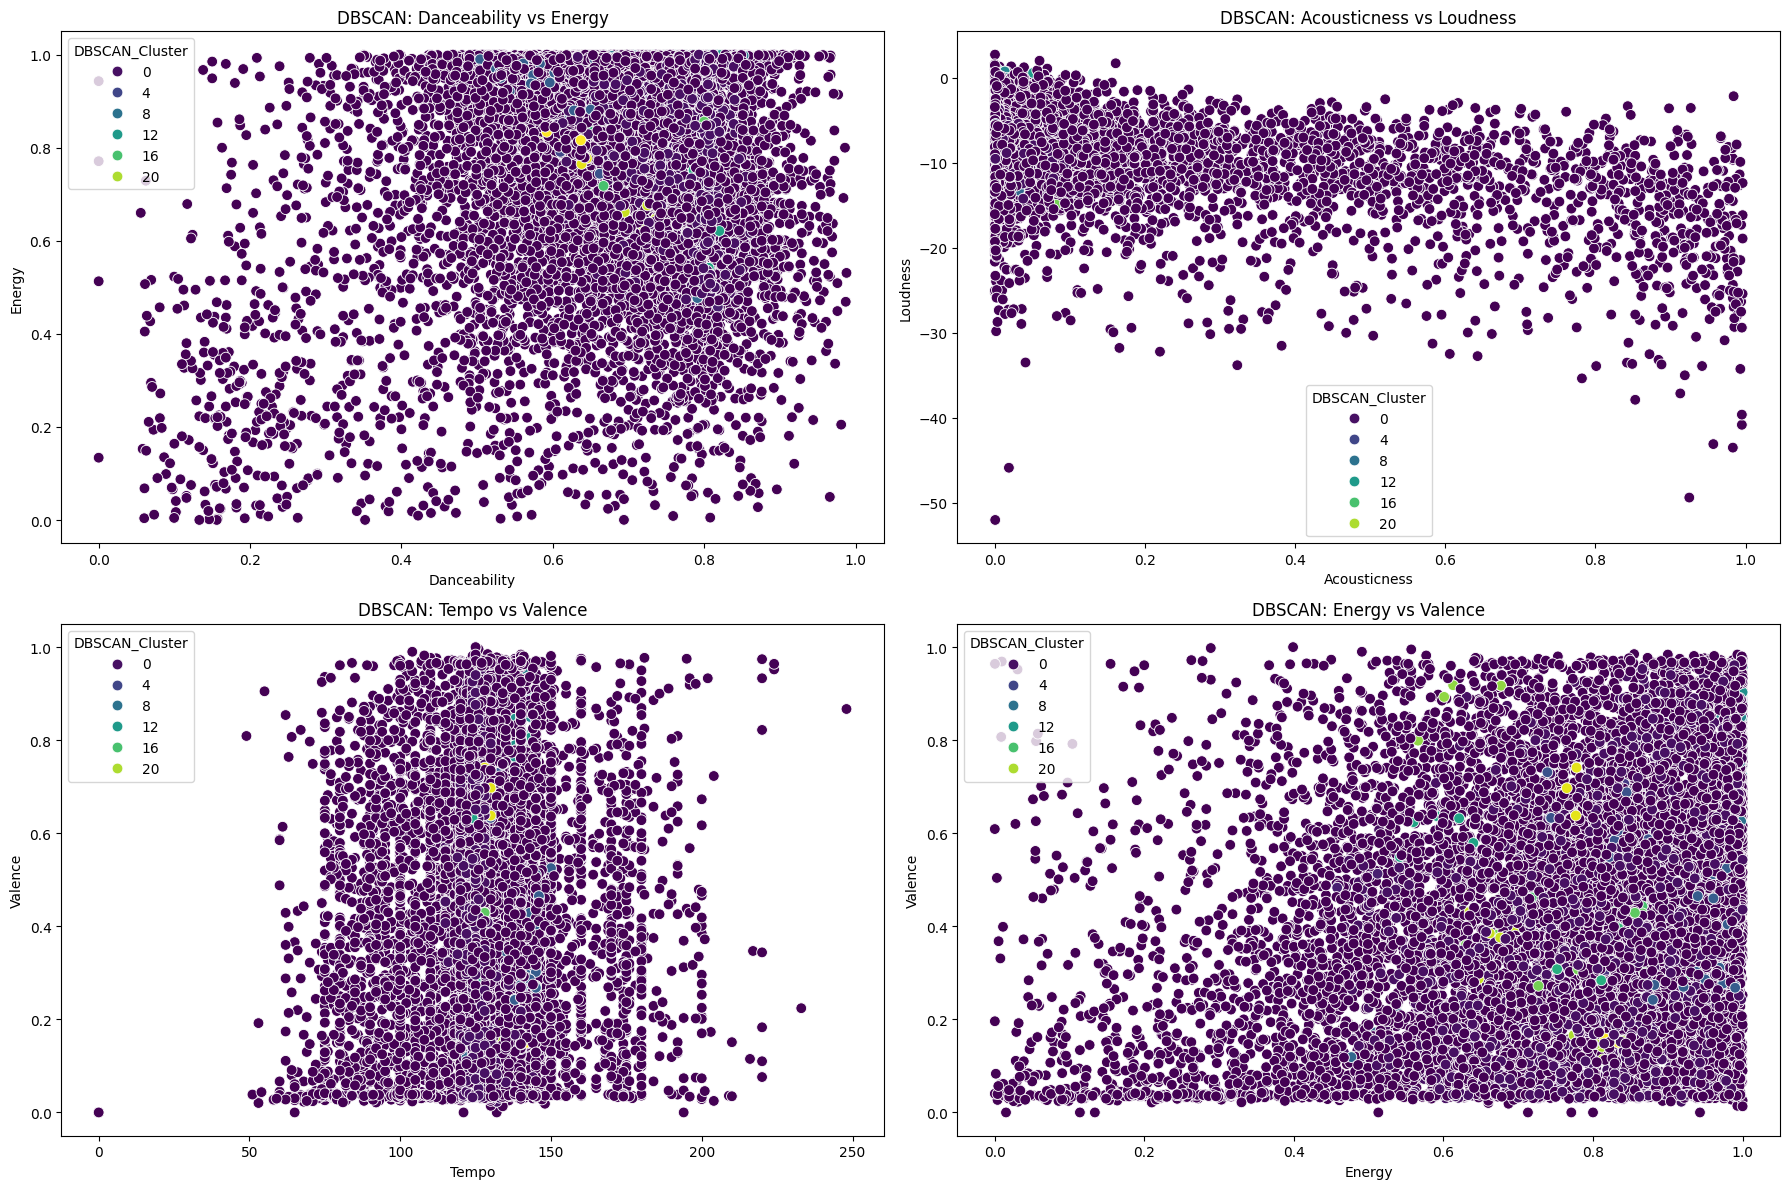

In [60]:
# Plotting DBSCAN Clustering results
plt.figure(figsize=(18, 12))

# Danceability vs. Energy
plt.subplot(2, 2, 1)
sns.scatterplot(data=pandas_df, x="danceability", y="energy", hue="DBSCAN_Cluster", palette="viridis", s=60)
plt.title("DBSCAN: Danceability vs Energy")
plt.xlabel("Danceability")
plt.ylabel("Energy")

# Acousticness vs. Loudness
plt.subplot(2, 2, 2)
sns.scatterplot(data=pandas_df, x="acousticness", y="loudness", hue="DBSCAN_Cluster", palette="viridis", s=60)
plt.title("DBSCAN: Acousticness vs Loudness")
plt.xlabel("Acousticness")
plt.ylabel("Loudness")

# Tempo vs. Valence
plt.subplot(2, 2, 3)
sns.scatterplot(data=pandas_df, x="tempo", y="valence", hue="DBSCAN_Cluster", palette="viridis", s=60)
plt.title("DBSCAN: Tempo vs Valence")
plt.xlabel("Tempo")
plt.ylabel("Valence")

# Energy vs. Valence
plt.subplot(2, 2, 4)
sns.scatterplot(data=pandas_df, x="energy", y="valence", hue="DBSCAN_Cluster", palette="viridis", s=60)
plt.title("DBSCAN: Energy vs Valence")
plt.xlabel("Energy")
plt.ylabel("Valence")

plt.tight_layout()
plt.show()


In [61]:
# Calculate silhouette score for KMeans and DBSCAN
from sklearn.metrics import silhouette_score


In [62]:
kmeans_silhouette = silhouette_score(standardized_data, kmeans_labels)
print(f"KMeans Silhouette Score: {kmeans_silhouette}")

KMeans Silhouette Score: 0.11541662365198135


In [63]:
# DBSCAN silhouette score (excluding noise points labeled as -1)
dbscan_silhouette = silhouette_score(standardized_data[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")

DBSCAN Silhouette Score: -0.2520151734352112


# Model

In [47]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt


In [49]:
# Step 1: Vector Assembly
# Focus on the key feature: Tempo
key_feature = ['bpm','danceability','energy','valence']  # Use the actual column name from your DataFrame

# Vector assembly for the key feature only
vec_assembler = VectorAssembler(inputCols=key_feature, outputCol='features')
final_data = vec_assembler.transform(normalized_df)
final_data

# Normalizing the data
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scalerModel = scaler.fit(final_data)
final_data = scalerModel.transform(final_data)

In [50]:
final_data

+--------------------+--------+--------------------+----------+-----+------------+------------+-----------+------+----------------+--------+--------+-----------+-----+-------+--------------+-----------------------+-----------------------+-------------------+---------------------------+-------------------+-------------------+----------------------+----------------+--------------------+--------------------+--------------------+
|         track_title|explicit|               title|is_remixed|  bpm|acousticness|danceability|duration_ms|energy|instrumentalness|liveness|loudness|speechiness|tempo|valence|bpm_normalized|acousticness_normalized|danceability_normalized|  energy_normalized|instrumentalness_normalized|liveness_normalized|loudness_normalized|speechiness_normalized|tempo_normalized|  valence_normalized|            features|      scaledFeatures|
+--------------------+--------+--------------------+----------+-----+------------+------------+-----------+------+----------------+--------+--------+-----------+-----+-------+--------------+-----------------------+-----------------------+-------------------+---------------------------+-------------------+-------------------+----------------------+----------------+--------------------+--------------------+--------------------+
|                Pink|       0|                Pink|         0| 84.0|      0.0173|       0.519|     212296| 0.671|         1.64E-5|    0.36|  -7.844|      0.459|127.0|  0.337|         0.336|    0.01730000041425228|     0.5189999938011169| 0.6710000038146973|       1.639999936742242...|0.36000001430511475| 0.8692666371663411|   0.45899999141693115|           0.508|  0.3370000123977661|[84.0,0.518999993...|[-1.5901983777447...|
|              Aelien|       0|              Aelien|         0|135.0|      0.0087|       0.523|     156889| 0.493|           0.789|   0.146|  -6.805|     0.0296|135.0|  0.118|          0.54|   0.008700000122189522|     0.5230000019073486|0.49300000071525574|         0.7889999747276306| 0.1459999978542328| 0.8865833282470703|  0.029600000008940697|            0.54| 0.11800000071525574|[135.0,0.52300000...|[0.68171723555902...|
|             Pilunja|       0|Pilunja feat. Naj...|         0|120.0|      0.0305|       0.385|     224700| 0.348|           0.838|   0.213| -13.338|      0.156|217.0|  0.347|          0.48|   0.030500000342726707|    0.38499999046325684| 0.3479999899864197|         0.8379999995231628|0.21299999952316284| 0.7776999791463216|   0.15600000321865082|           0.868| 0.34700000286102295|[120.0,0.38499999...|[0.01350676105790...|
|        21st Century|       0|        21st Century|         0|120.0|        0.61|        0.53|     279060| 0.599|            0.96|  0.0736|  -9.039|     0.0379|120.0|  0.145|          0.48|     0.6100000143051147|     0.5299999713897705| 0.5989999771118164|         0.9599999785423279|0.07360000163316727| 0.8493499755859375|   0.03790000081062317|            0.48| 0.14499999582767487|[120.0,0.52999997...|[0.01350676105790...|
|        All at First|       0|        All at First|         0| 90.0|        0.37|       0.596|     291320| 0.384|           0.333|    0.14| -16.141|      0.035|120.0|   0.13|          0.36|     0.3700000047683716|     0.5960000157356262| 0.3840000033378601|         0.3330000042915344|0.14000000059604645| 0.7309833526611328|   0.03500000014901161|            0.48| 0.12999999523162842|[90.0,0.596000015...|[-1.3229141879443...|
|Life (Lounge Vers...|       0|Life (Lounge Vers...|         0|120.0|        0.63|       0.593|     246740| 0.432|          0.0227|   0.238| -12.591|      0.044|120.0|  0.395|          0.48|     0.6299999952316284|     0.5929999947547913| 0.4320000112056732|       0.022700000554323196|0.23800000548362732|  0.790150006612142|   0.04399999976158142|            0.48| 0.39500001072883606|[120.0,0.59299999...|[0.01350676105790...|
|               Round|       0|               Round|         0| 68.0|       0.166|       0.458|     259556| 0.962|           0.789

In [51]:
# Step 2: K-means clustering and silhouette evaluation
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')

def evaluate_kmeans(k, data):
    kmeans = KMeans(featuresCol='features', k=k)
    model = kmeans.fit(data)
    predictions = model.transform(data)
    return evaluator.evaluate(predictions)



In [52]:
# Test a range of k values and store the silhouette scores
k_values = range(2, 10)
silhouette_scores = [(k, evaluate_kmeans(k, final_data)) for k in k_values]

# Print the silhouette scores for each k
for k, score in silhouette_scores:
    print('Silhouette Score for k =', k, 'is', score)

Silhouette Score for k = 2 is 0.919867059171467
Silhouette Score for k = 3 is 0.7705995104542266
Silhouette Score for k = 4 is 0.6868609069631259
Silhouette Score for k = 5 is 0.7434869220068714
Silhouette Score for k = 6 is 0.7544225713469734
Silhouette Score for k = 7 is 0.7815237960217776
Silhouette Score for k = 8 is 0.775849053583554
Silhouette Score for k = 9 is 0.7212127482521122


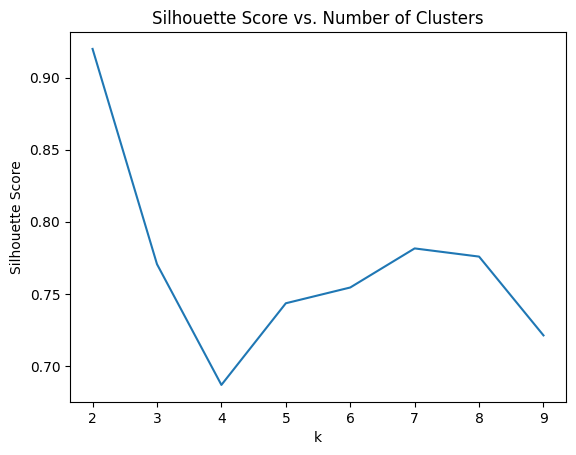

In [53]:
# Optional: Plotting silhouette scores for visual analysis
plt.plot(k_values, [score for k, score in silhouette_scores])
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.savefig("silhouette_score.png")
plt.show()

In [54]:
# Fit the final K-means model with the best k
final_kmeans = KMeans(featuresCol='features', k=7)
final_model = final_kmeans.fit(final_data)
final_predictions = final_model.transform(final_data)
final_score = evaluator.evaluate(final_predictions)


In [55]:
print(f"Final silhouette score with k=7 is {final_score}")

Final silhouette score with k=7 is 0.7815237960217776


In [56]:
# Printing cluster centers
centers = final_model.clusterCenters()
print("Cluster Centers:")
for center in centers:
    print(center)

Cluster Centers:
[125.21949711   0.72014577   0.71319327   0.45568916]
[0.         0.43918182 0.45642    0.28643818]
[88.8750952   0.60364174  0.63542627  0.40067578]
[162.51097179   0.54188056   0.66901429   0.3855605 ]
[141.61672843   0.65687125   0.84108471   0.51741885]
[106.39185751   0.64420755   0.61046172   0.42283308]
[71.04071247  0.61395318  0.65571807  0.37231603]


In [57]:
print(final_predictions.columns)

['track_title', 'explicit', 'title', 'is_remixed', 'bpm', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'bpm_normalized', 'acousticness_normalized', 'danceability_normalized', 'energy_normalized', 'instrumentalness_normalized', 'liveness_normalized', 'loudness_normalized', 'speechiness_normalized', 'tempo_normalized', 'valence_normalized', 'features', 'scaledFeatures', 'prediction']


In [71]:
import numpy as np

# Recommendation function using feature similarity
def recommend_songs_by_features(song_title, predictions_df, num_recommendations=5):
    input_song = predictions_df.filter(predictions_df.track_title == song_title).first()
    if not input_song:
        print("Song not found.")
        return []
    
    # Extract features for the input song
    input_features = np.array([input_song.bpm, input_song.danceability, input_song.energy, input_song.valence])
    
    # Calculate distances to all other songs
    predictions_df = predictions_df.filter(predictions_df.track_title != song_title)  # Exclude the input song
    distances = []

    for song in predictions_df.collect():
        song_features = np.array([song.bpm, song.danceability, song.energy, song.valence])
        distance = np.linalg.norm(input_features - song_features)  # Euclidean distance
        distances.append((song, distance))
    
    # Sort by distance and get the nearest songs
    distances.sort(key=lambda x: x[1])  # Sort by distance
    recommendations = [(song[0].track_title, song[1]) for song in distances[:num_recommendations]]  # Get the song titles and distances
    
    return recommendations

# Example usage
song_to_recommend = "Step"
recommendations = recommend_songs_by_features(song_to_recommend, final_predictions)

print(f"Recommendations for '{song_to_recommend}':")
for track_title, distance in recommendations:
    print(f"Title: {track_title}, Distance: {distance:.3f}")  

Recommendations for 'Step':
Title: U Know, Distance: 0.160
Title: How Many Lies?, Distance: 0.276
Title: 5 Colors Black (Monophobe Remix), Distance: 0.281
Title: None, Distance: 0.285
Title: Castaway, Distance: 0.317


In [ ]:
#  # Select numerical columns and convert them to FloatType
# numerical_cols = ["bpm", "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence"]
# for column in numerical_cols:
#     joined_df = joined_df.withColumn(column, col(column).cast(FloatType()))

# # Convert Spark DataFrame to Pandas DataFrame for easier manipulation in Scikit-learn
# pandas_df = joined_df.toPandas()

# # Fill any null values in numerical columns with column means
# pandas_df.fillna(pandas_df.mean(), inplace=True)

# # Standardize numerical features
# scaler = StandardScaler()
# standardized_data = scaler.fit_transform(pandas_df[numerical_cols])

# # K-Means Clustering
# kmeans = KMeans(n_clusters=5, random_state=42)
# kmeans_labels = kmeans.fit_predict(standardized_data)
# pandas_df['KMeans_Cluster'] = kmeans_labels

# # DBSCAN Clustering
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# dbscan_labels = dbscan.fit_predict(standardized_data)
# pandas_df['DBSCAN_Cluster'] = dbscan_labels

# # Plotting KMeans Clustering results
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# sns.scatterplot(data=pandas_df, x="danceability", y="energy", hue="KMeans_Cluster", palette="viridis", s=60)
# plt.title("K-Means Clustering")
# plt.xlabel("Danceability")
# plt.ylabel("Energy")

# # Plotting DBSCAN Clustering results
# plt.subplot(1, 2, 2)
# sns.scatterplot(data=pandas_df, x="danceability", y="energy", hue="DBSCAN_Cluster", palette="viridis", s=60)
# plt.title("DBSCAN Clustering")
# plt.xlabel("Danceability")
# plt.ylabel("Energy")
# plt.show()

# # Calculate silhouette score for KMeans and DBSCAN
# from sklearn.metrics import silhouette_score

# kmeans_silhouette = silhouette_score(standardized_data, kmeans_labels)
# print(f"KMeans Silhouette Score: {kmeans_silhouette}")

# # DBSCAN silhouette score (excluding noise points labeled as -1)
# dbscan_silhouette = silhouette_score(standardized_data[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
# print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")

# # Heatmap for correlation analysis
# correlation_matrix = pandas_df[numerical_cols].corr()
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
# plt.title("Feature Correlation Heatmap")
# plt.show()